In [ ]:
pip install faiss-cpu

In [2]:
!pip install scikit-learn --upgrade

In [3]:
import torch
import timm
import faiss
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
model = timm.create_model("convnext_tiny", pretrained=True, num_classes=0)
model.eval().to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)


In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [7]:
def load_cifar100():
    dataset = datasets.CIFAR100(root="./data", train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=2)
    return dataset, dataloader


In [8]:
def get_convnext_embeddings(dataloader):
    all_features = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            features = model(images)
            all_features.append(features.cpu().numpy())
    return np.vstack(all_features)


In [9]:
def build_faiss_index(embeddings):
    index = faiss.IndexFlatL2(embeddings.shape[1])
    index.add(embeddings)
    return index



In [10]:
def faiss_search(index, query_embedding, k=50):
    _, indices = index.search(query_embedding, k)
    return indices[0]


In [11]:
def compute_metrics(retrieved_indices, query_labels, database_labels, k=50):
    total_tp, total_fp = 0, 0
    for i in range(len(query_labels)):
        retrieved = retrieved_indices[i]
        retrieved_labels = database_labels[retrieved]
        tp = np.sum(retrieved_labels == query_labels[i])
        fp = k - tp
        total_tp += tp
        total_fp += fp
    total_retrieved = len(query_labels) * k
    return total_tp / total_retrieved, total_fp / total_retrieved


In [12]:
def show_results(query_img, faiss_idxs, original_dataset, query_label=None, faiss_precision=None, faiss_fpr=None):
    fig = plt.figure(figsize=(20, 12))
    ax = plt.subplot(6, 10, 1)
    ax.imshow(query_img.permute(1, 2, 0))
    ax.set_title("Query\n(Class: Unknown)" if query_label is None else f"Query\n(Class: {label_names[query_label]})")
    ax.axis("off")
    for i, idx in enumerate(faiss_idxs[:50]):
        img, label = original_dataset[idx]
        ax = plt.subplot(6, 10, i + 2)
        ax.imshow(img.permute(1, 2, 0).clamp(0, 1))
        ax.set_title(f"FAISS {i+1}\n{label_names[label]}", fontsize=8)
        ax.axis("off")
    if faiss_precision is not None:
        fig.suptitle(f"Precision: {faiss_precision:.3f} | FPR: {faiss_fpr:.3f}", fontsize=16)
    plt.tight_layout()
    plt.show()



Loading dataset and model...


100%|██████████| 169M/169M [00:12<00:00, 13.1MB/s]



Query 1 (Index: 300, Label: plain):
Top-10: Precision = 0.600, FPR = 0.400
Top-20: Precision = 0.450, FPR = 0.550
Top-30: Precision = 0.367, FPR = 0.633
Top-40: Precision = 0.350, FPR = 0.650
Top-50: Precision = 0.380, FPR = 0.620


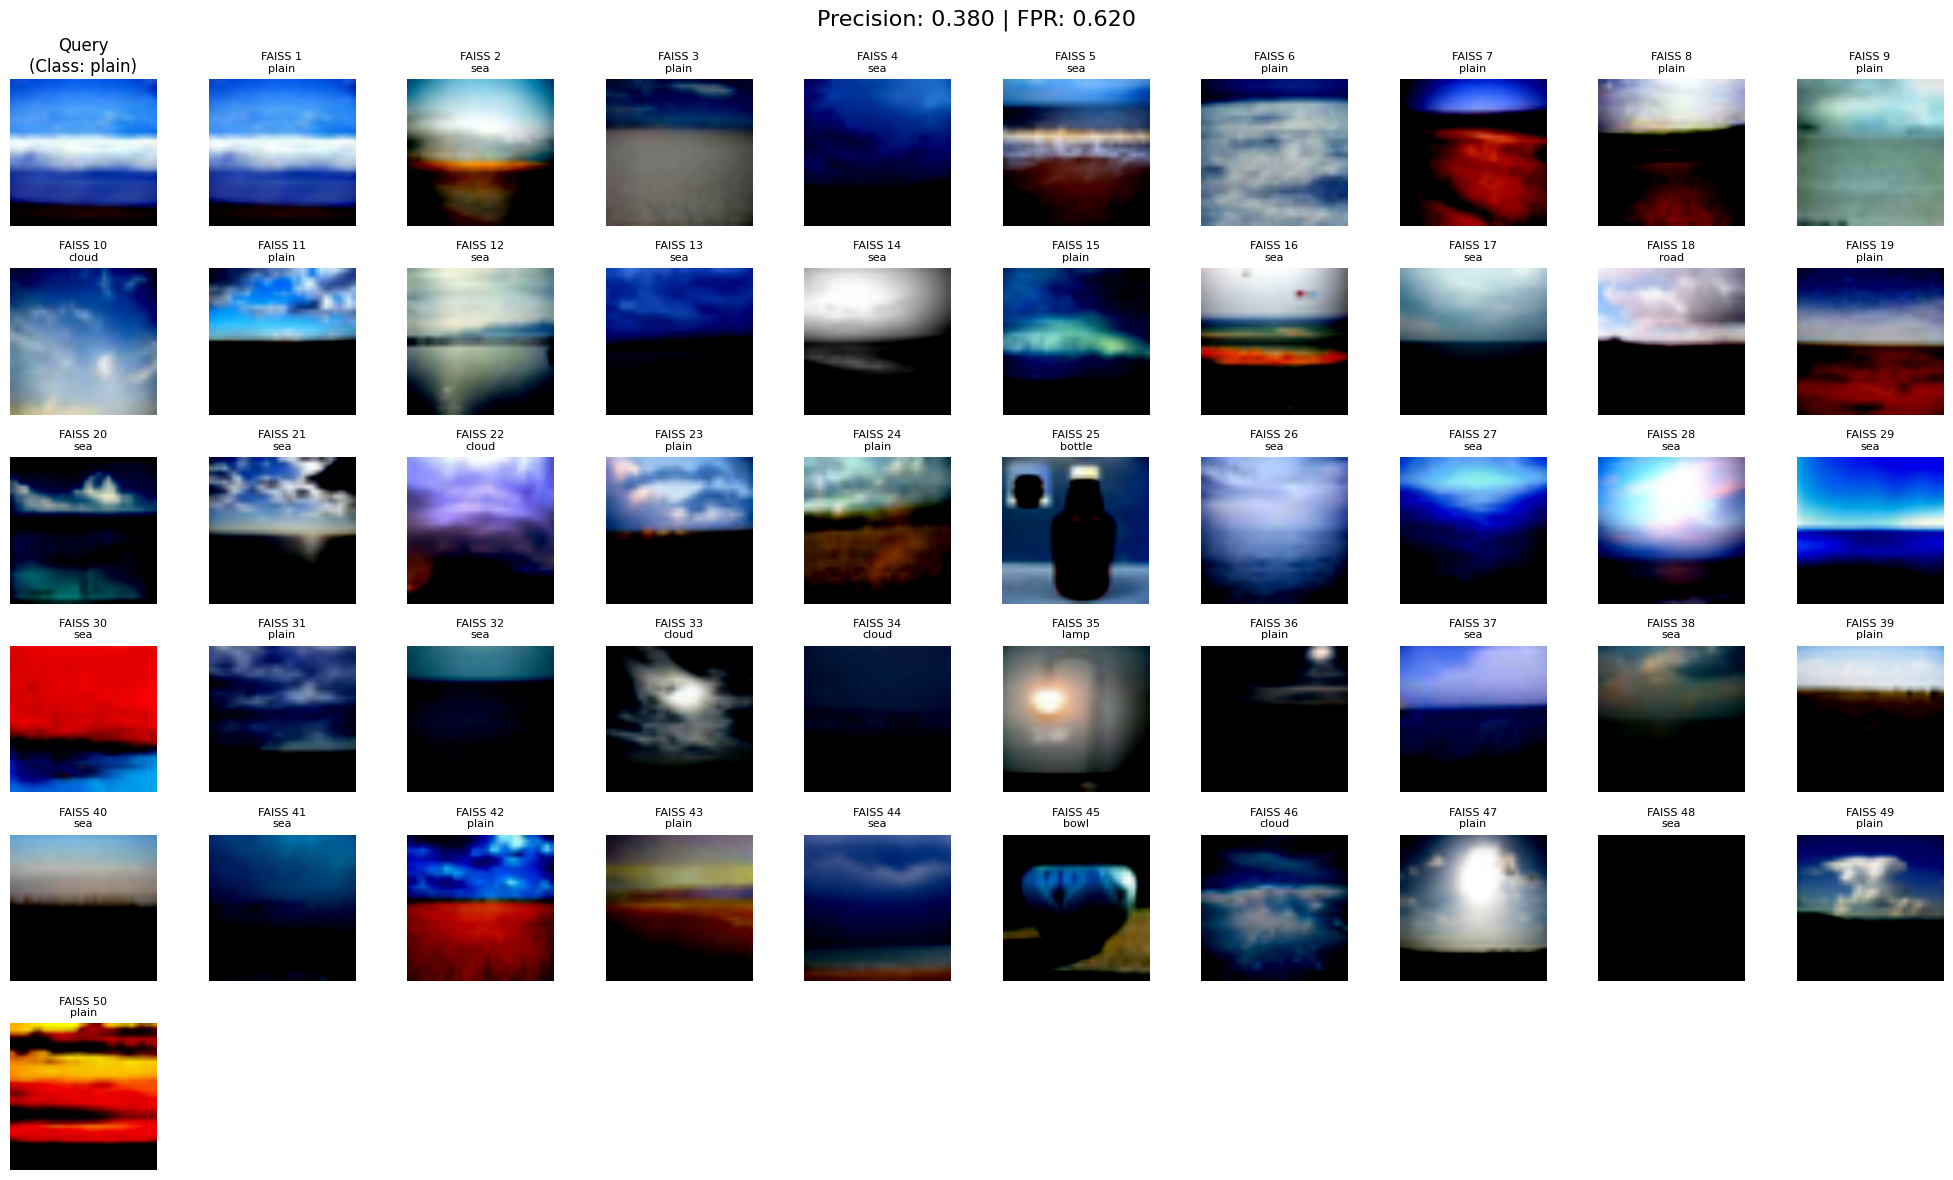


Query 2 (Index: 10, Label: keyboard):
Top-10: Precision = 1.000, FPR = 0.000
Top-20: Precision = 1.000, FPR = 0.000
Top-30: Precision = 1.000, FPR = 0.000
Top-40: Precision = 1.000, FPR = 0.000
Top-50: Precision = 1.000, FPR = 0.000


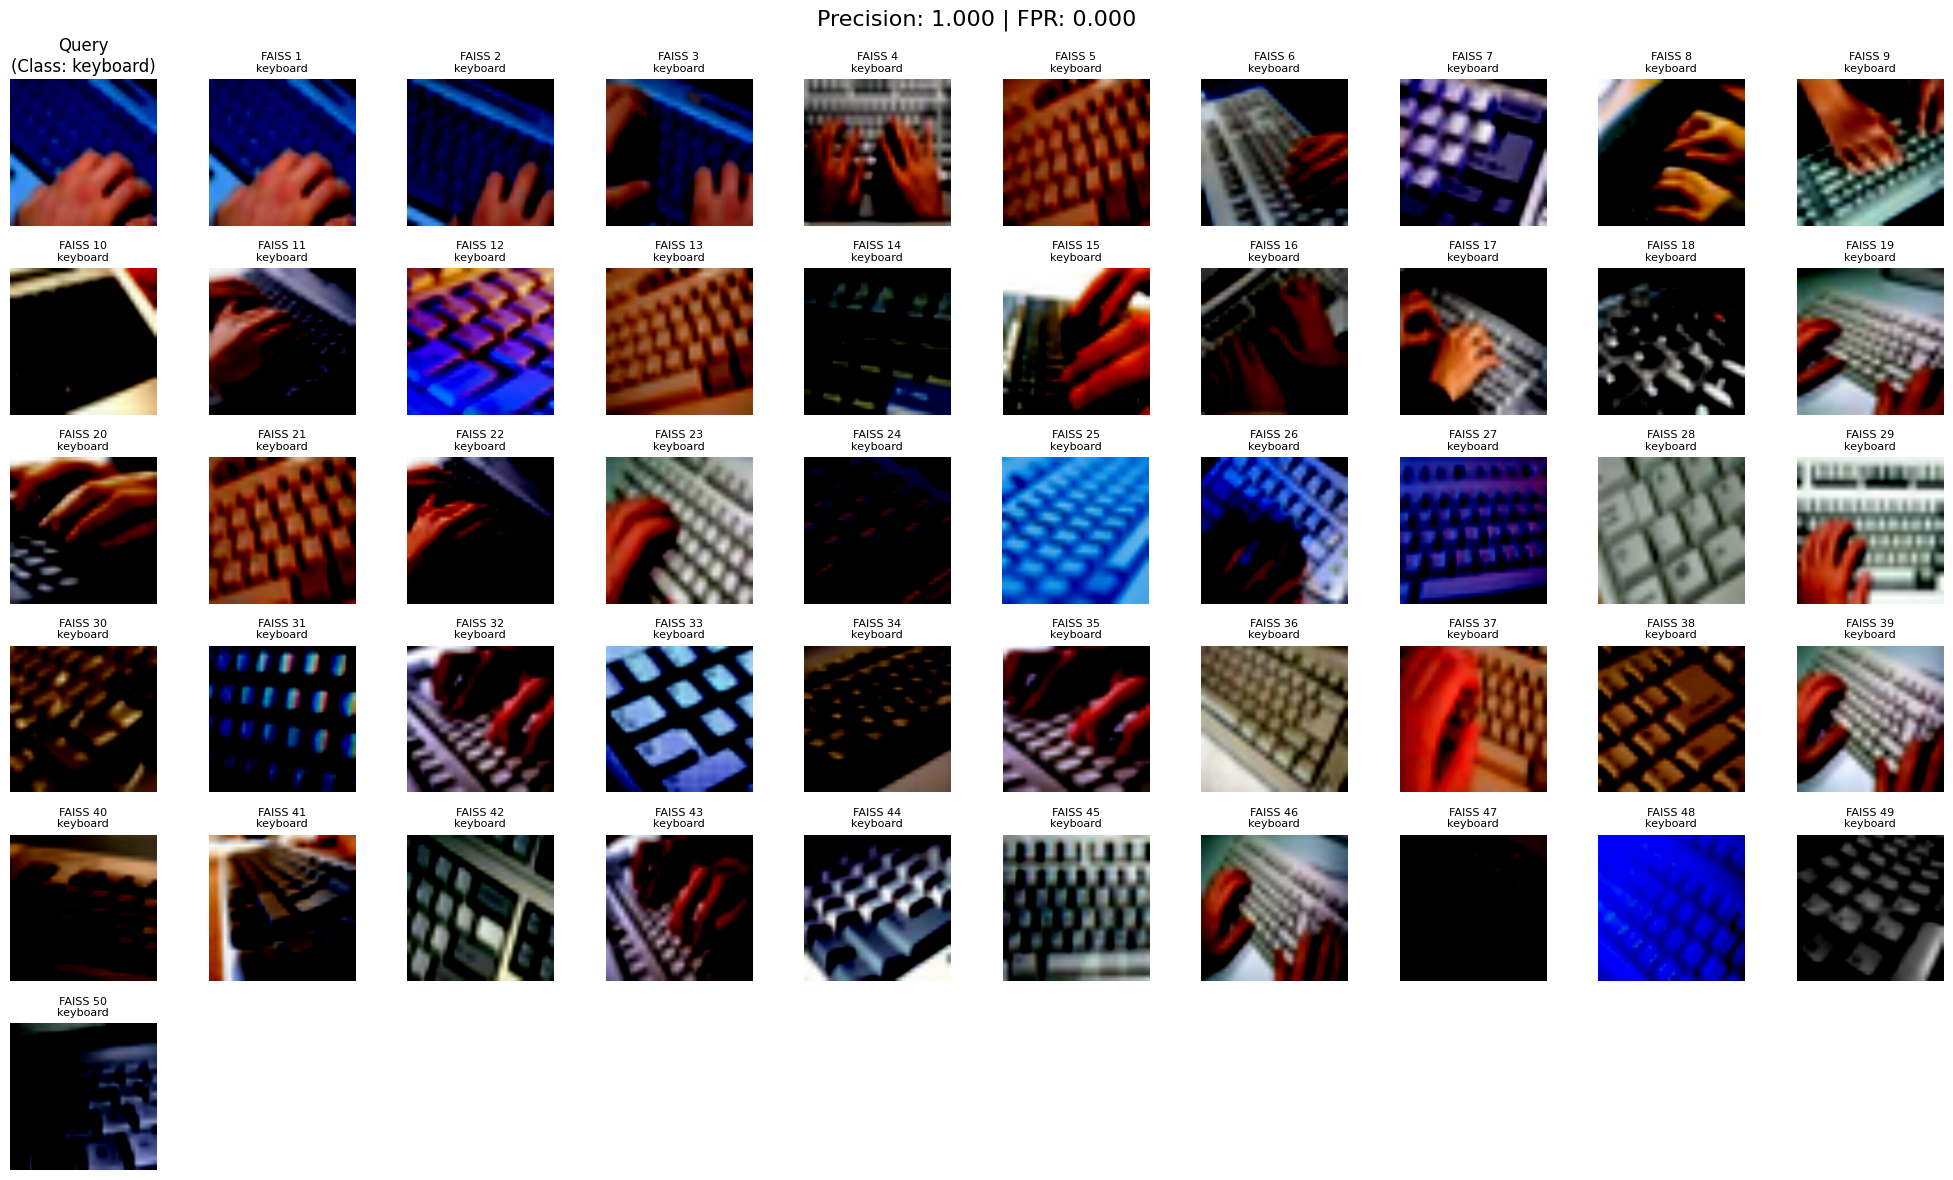


Query 3 (Index: 3330, Label: tractor):
Top-10: Precision = 0.900, FPR = 0.100
Top-20: Precision = 0.700, FPR = 0.300
Top-30: Precision = 0.800, FPR = 0.200
Top-40: Precision = 0.775, FPR = 0.225
Top-50: Precision = 0.760, FPR = 0.240


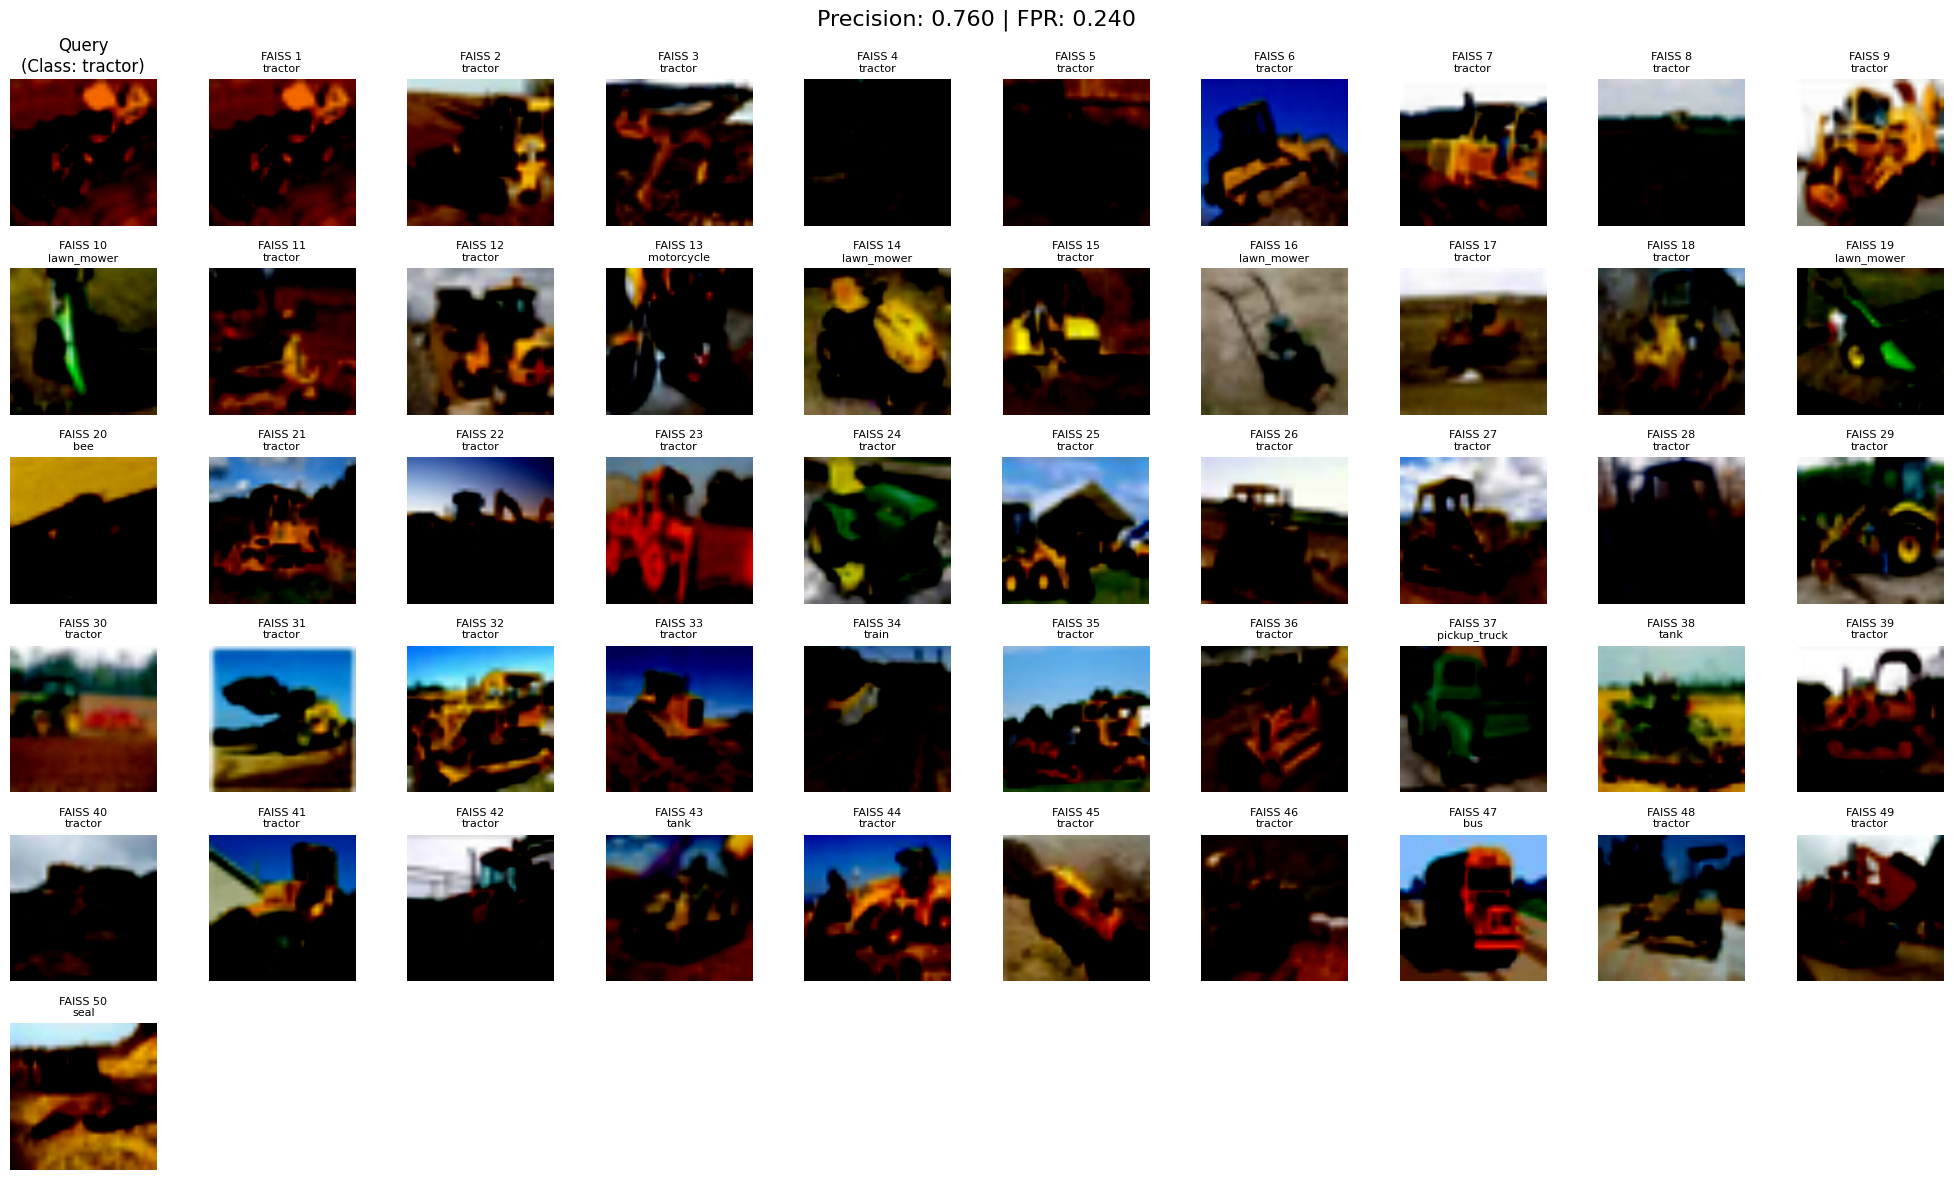


Query 4 (Index: 1024, Label: hamster):
Top-10: Precision = 0.900, FPR = 0.100
Top-20: Precision = 0.950, FPR = 0.050
Top-30: Precision = 0.967, FPR = 0.033
Top-40: Precision = 0.975, FPR = 0.025
Top-50: Precision = 0.980, FPR = 0.020


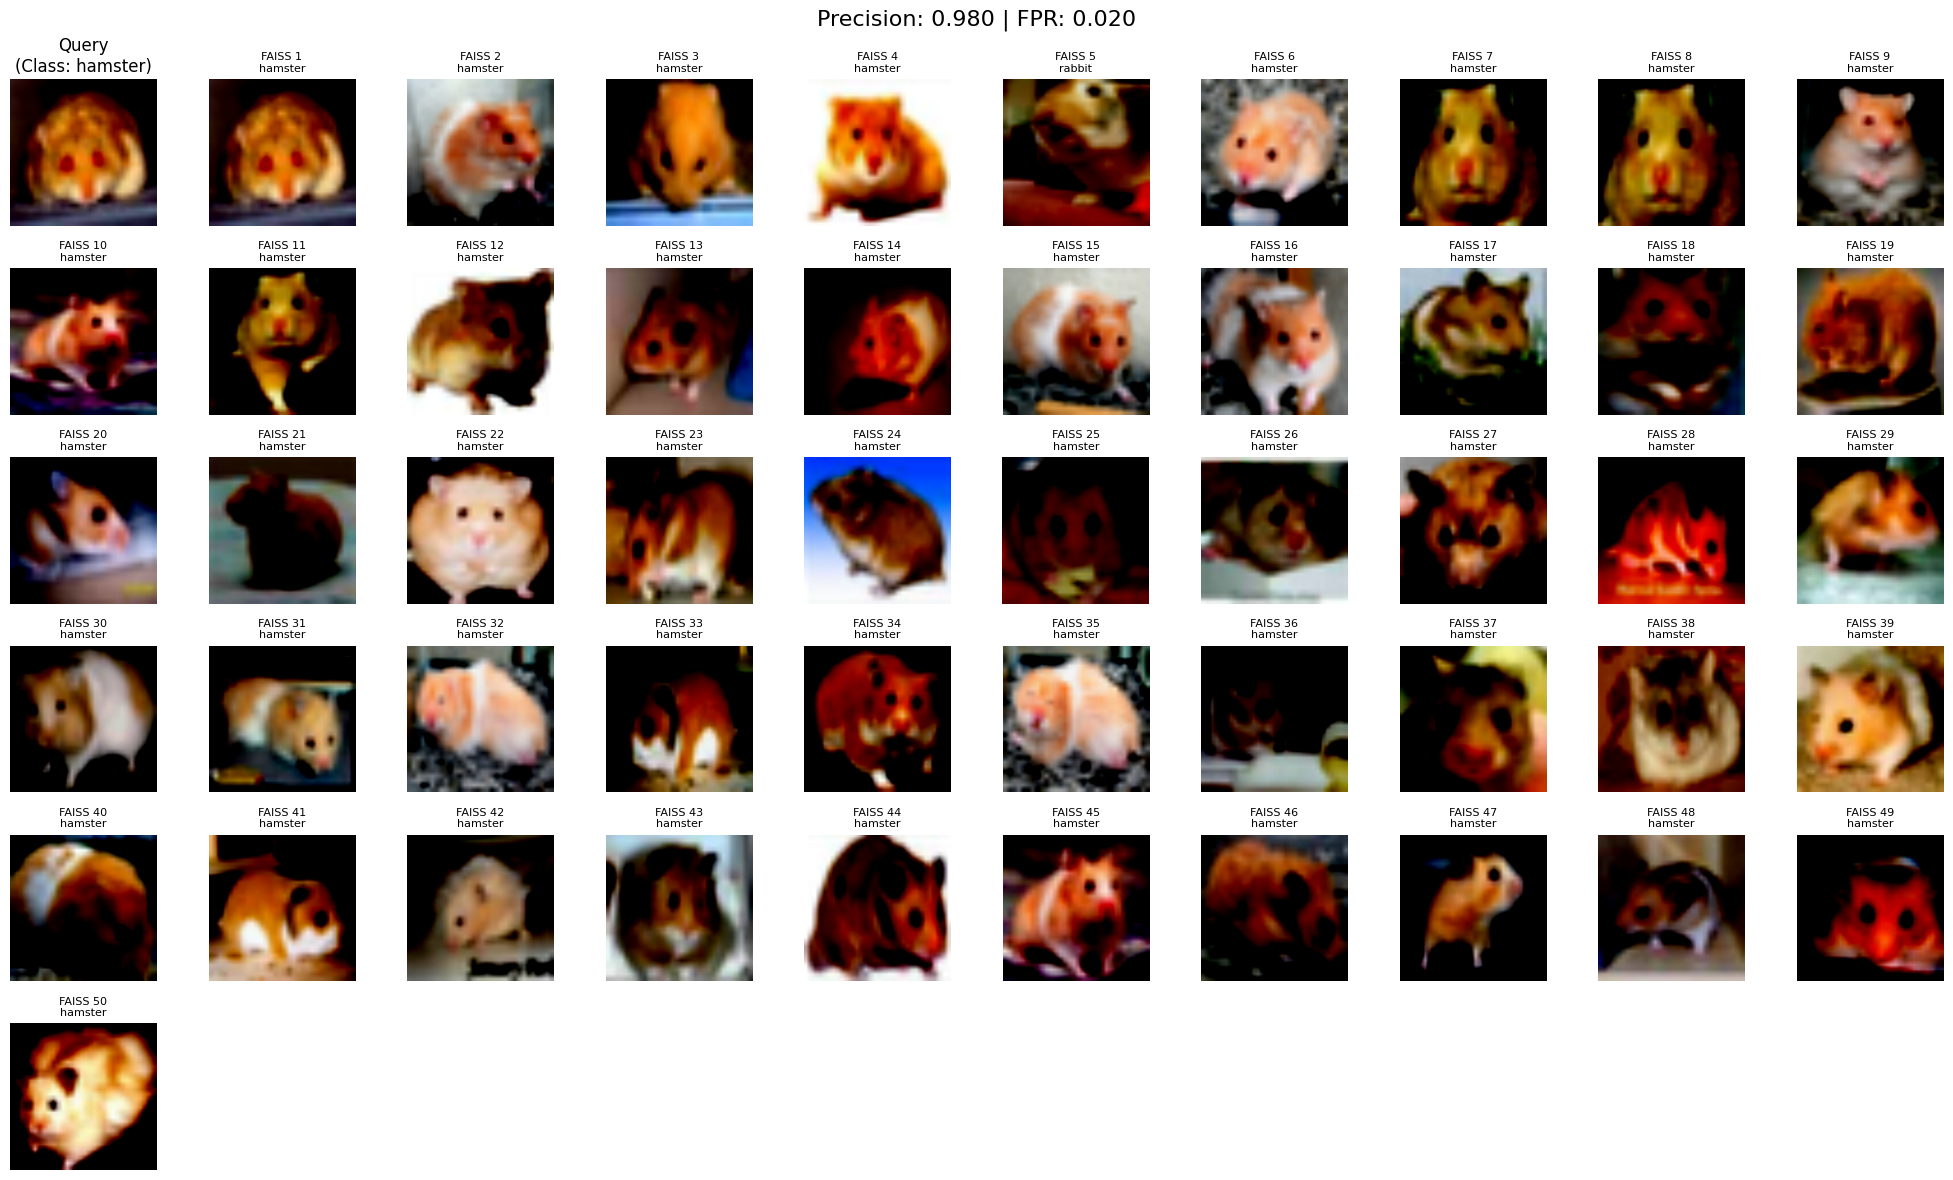


Query 5 (Index: 5789, Label: castle):
Top-10: Precision = 0.900, FPR = 0.100
Top-20: Precision = 0.850, FPR = 0.150
Top-30: Precision = 0.833, FPR = 0.167
Top-40: Precision = 0.850, FPR = 0.150
Top-50: Precision = 0.880, FPR = 0.120


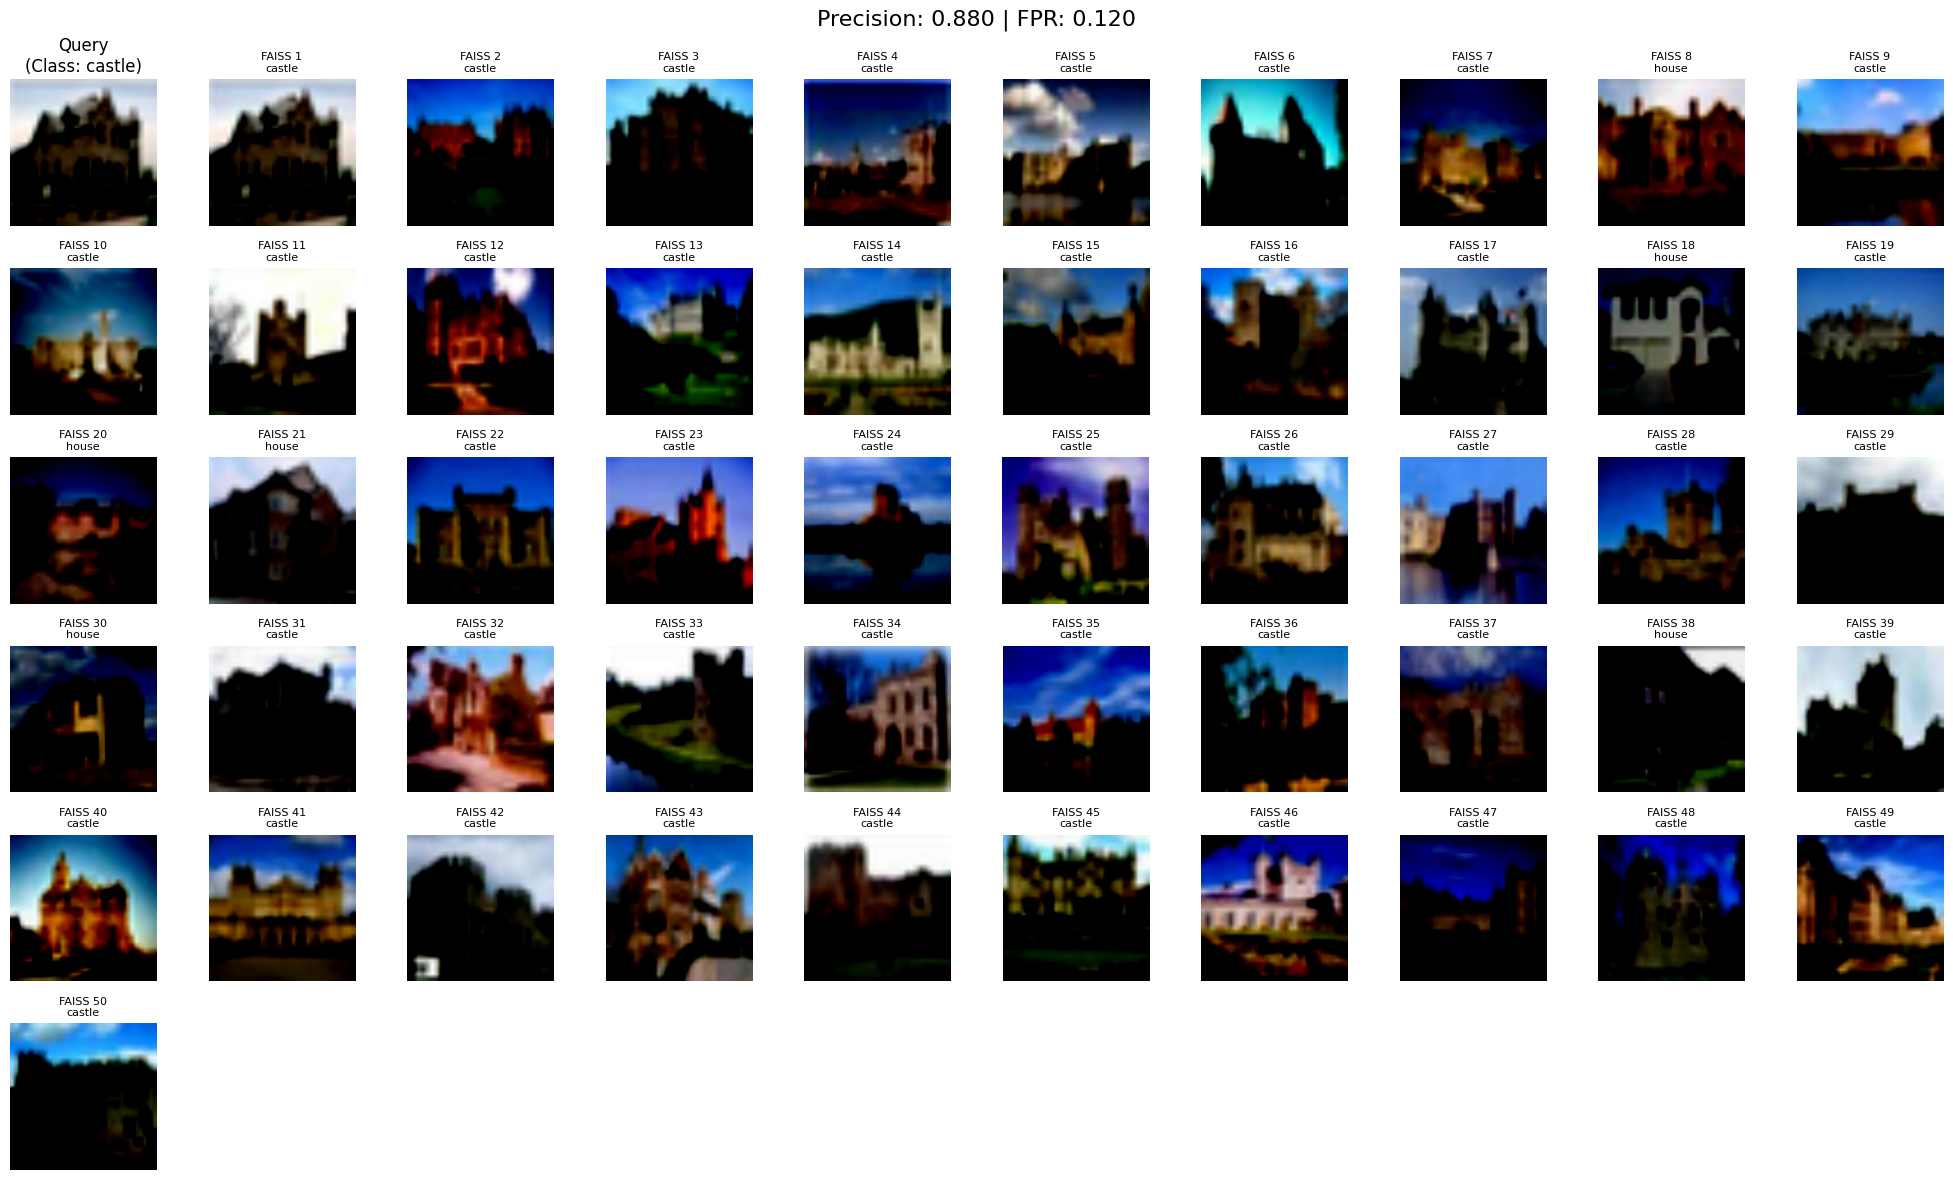

In [13]:
if __name__ == "__main__":
    print("Loading dataset and model...")
    dataset, dataloader = load_cifar100()
    label_names = dataset.classes
    labels = np.array(dataset.targets)

    embeddings = get_convnext_embeddings(dataloader)
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    faiss_index = build_faiss_index(embeddings)

    original_dataset = datasets.CIFAR100(root="./data", train=True, download=False, transform=transform)
    query_indices = [300, 10, 3330, 1024, 5789]
    ks = [10, 20, 30, 40, 50]

    for i, query_idx in enumerate(query_indices):
        query_img, query_label = original_dataset[query_idx]
        query_img_tensor = query_img.unsqueeze(0).to(device)

        with torch.no_grad():
            query_embedding = model(query_img_tensor)
            query_embedding /= query_embedding.norm(dim=-1, keepdim=True)
            query_embedding = query_embedding.cpu().numpy()

        faiss_results = faiss_search(faiss_index, query_embedding, k=100)
        print(f"\nQuery {i+1} (Index: {query_idx}, Label: {label_names[query_label]}):")
        for k in ks:
            precision_k, fpr_k = compute_metrics([faiss_results[:k]], [query_label], labels, k)
            print(f"Top-{k}: Precision = {precision_k:.3f}, FPR = {fpr_k:.3f}")
        show_results(query_img, faiss_results, original_dataset, query_label, precision_k, fpr_k)


Processing custom image: /content/istockphoto-94323862-612x612 (1).jpg


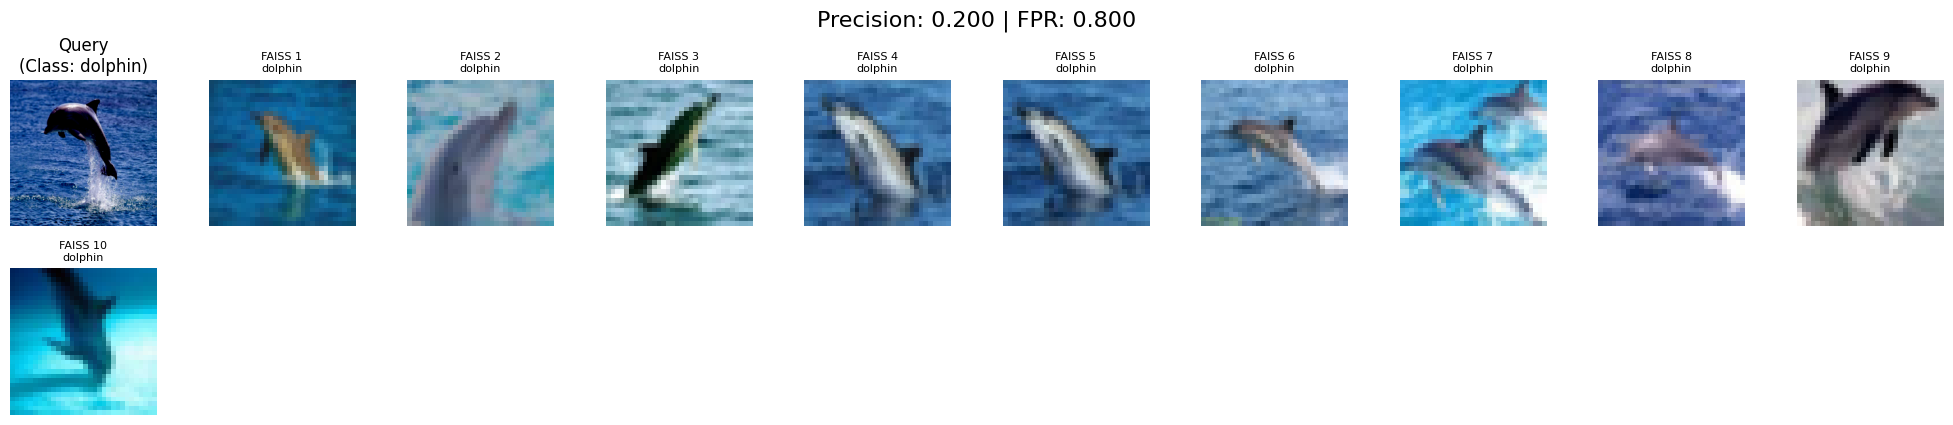


Processing custom image: /content/images (2).jpg


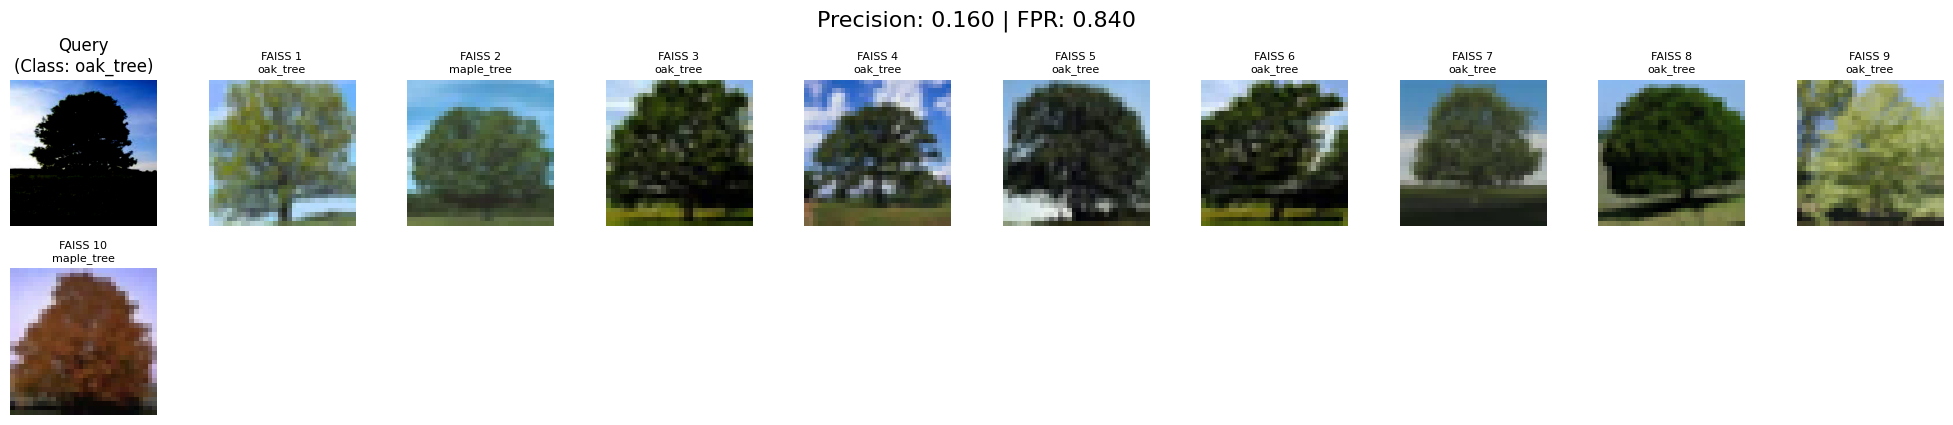


Processing custom image: /content/images (3).jpg


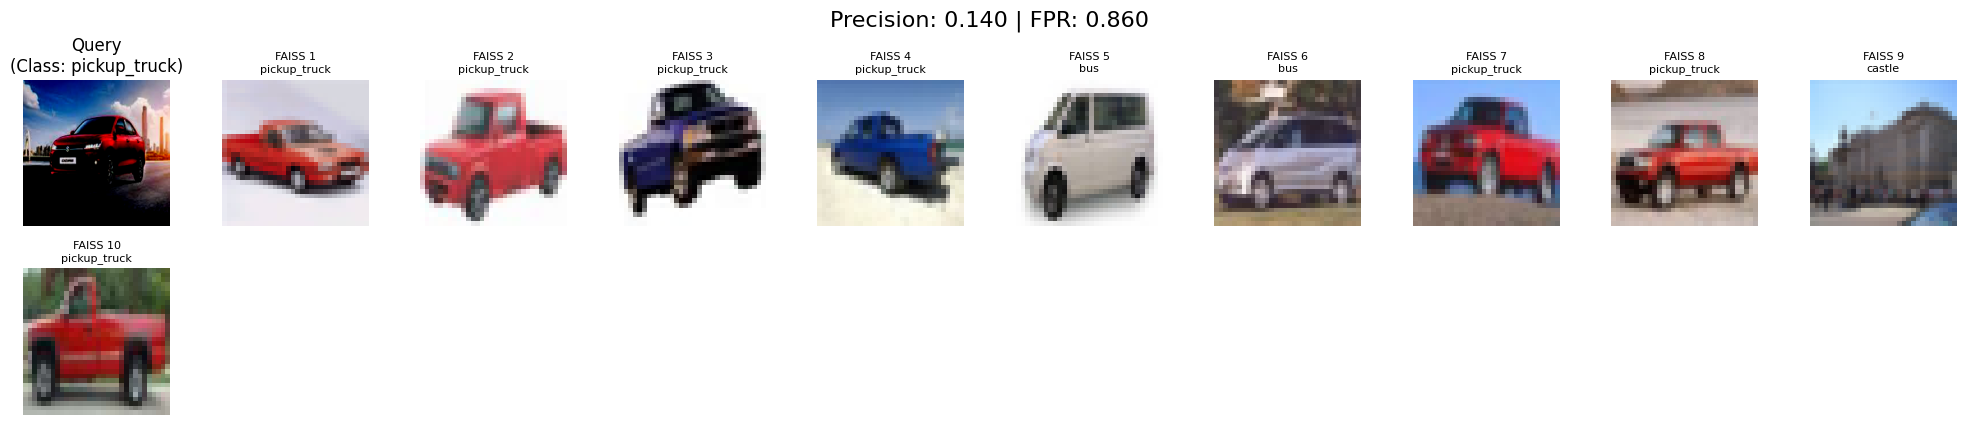

In [14]:
from PIL import Image

# Load original dataset without normalization for visualization
original_dataset = datasets.CIFAR100(root="./data", train=True, download=False, transform=transforms.ToTensor())
custom_image_paths = [
    "/content/istockphoto-94323862-612x612 (1).jpg",
    "/content/images (2).jpg",
    "/content/images (3).jpg"
]

all_query_embeddings = []
all_faiss_results = []

for i, path in enumerate(custom_image_paths):
    print(f"\nProcessing custom image: {path}")
    img = Image.open(path).convert("RGB")
    query_img = transform(img)  # apply Resize, ToTensor, Normalize
    input_tensor = query_img.unsqueeze(0).to(device)

    with torch.no_grad():
        query_embedding = model(input_tensor)  # Direct forward pass
        query_embedding = query_embedding / query_embedding.norm(dim=-1, keepdim=True)
        query_embedding = query_embedding.cpu().numpy()

    faiss_results = faiss_search(faiss_index, query_embedding, k=10)

    all_query_embeddings.append(query_embedding[0])
    all_faiss_results.append(faiss_results)

    predicted_label = labels[faiss_results[0]]
    query_label = predicted_label

    precision, fpr = compute_metrics([faiss_results], [query_label], labels)

    show_results(query_img, faiss_results, original_dataset,
                 query_label=query_label, faiss_precision=precision, faiss_fpr=fpr)
